In [1]:
# Reference: https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
import tensorflow as tf
opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
conf = tf.ConfigProto(gpu_options=opts)
tf.enable_eager_execution(config=conf)

/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

In [2]:
# Reference: https://stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation
# https://rare-technologies.com/word2vec-tutorial/
# Local: pip install gensim
# GCP: conda install gensim (pip instal didn't work)
import random
import sys
import os
import re
import numpy as np
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
import gensim
import matplotlib.pyplot as plt

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
# dir_split = f"../1.DataPreparationResults/obama"
# file_train = open(f"{dir_split}/train.txt", 'r').read()
# file_val = open(f"{dir_split}/val.txt", 'r').read()
# file_test = open(f"{dir_split}/test.txt", 'r').read()

# Windows ONLY
# dir_split = r"D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\1.DataPreparationResults\obama"
# file_train = open(f"{dir_split}\\train.txt", 'r').read()
# file_val = open(f"{dir_split}\\val.txt", 'r').read()
# file_test = open(f"{dir_split}\\test.txt", 'r').read()

In [5]:
rootdir = f"../1.DataPreparationResults"
files_train_lst = []
files_val_lst = []
files_test_lst = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'train.txt' in file:
            files_train_lst.append(os.path.join(subdir, file))
        elif 'val.txt' in file:
            files_val_lst.append(os.path.join(subdir, file))
        else:
            files_test_lst.append(os.path.join(subdir, file))

In [6]:
num_file = len(files_train_lst)

In [7]:
file_train = open(f"{files_train_lst[0]}", 'r').read()
file_val = open(f"{files_val_lst[0]}", 'r').read()
file_test = open(f"{files_test_lst[0]}", 'r').read()

In [8]:
x_len = 30
x_step = 1

In [9]:
# os.path.exists(u"gs://w266-final-project/GoogleNews-vectors-negative300.bin")
os.path.exists("../../test/GoogleNews-vectors-negative300.bin")

True

In [10]:
# Google pre-trained word2vec model
# Reference: https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/
# Reference: https://code.google.com/archive/p/word2vec/
# google_word_model = gensim.models.KeyedVectors.load_word2vec_format(r"D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\GoogleNews-vectors-negative300.bin", binary=True)

google_word_model = gensim.models.KeyedVectors.load_word2vec_format('../../test/GoogleNews-vectors-negative300.bin', binary=True)
pretrained_weights = google_word_model.wv.vectors
print(type(pretrained_weights))
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

<class 'numpy.ndarray'>
Result embedding shape: (3000000, 300)


/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [11]:
def word2idx(word):
    return google_word_model.wv.vocab[word].index
# def word2idx(word):
#     if word in google_word_model.wv.vocab:
#         return google_word_model.wv.vocab[word].index
#     # Capitalization matters in Google trained word2vec
#     # "united" is not equal to "United"
#     elif type(word[0]) == str:
#         word = word[0].lower() + word[1:]
#         if word in google_word_model.wv.vocab:
#             return google_word_model.wv.vocab[word].index
#     else:
#         return -1
def idx2word(idx):
    return google_word_model.wv.index2word[idx]

vocab = google_word_model.wv.vocab
# Confirm that word_model works
# print(word_model.wv.vocab["doubts"].index)

/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [12]:
# The following output is too large, which will make the notebook render super slowly
# for word in vocab:
#     if '_' in word:
#         print(word)

* Google pretrained words don't include 3 common stop words: 'a', 'and', 'of', and 'to'. Interestingly, it includes 'A', 'And', 'Of', and 'To'.  
* Google pretrained model assumes all digits are replaced by #.  
* Google combines common phrases with '_' (TO BE IMPLEMENTED)

In [13]:
def google_preprocess(file):
    # e.g., there is no harrison train.txt
    if len(file) != 0:
        file2 = re.sub('\d', '#', file)
        file2 = re.sub(' a ', ' A ', file2)
        file2 = re.sub(' and ', ' And ', file2)
        file2 = re.sub(' of ', ' Of ', file2)
        file2 = re.sub(' to ', ' To ', file2)
        file2 = re.sub(' , ', ' . ', file2)
        # Add spaces around <speech_sep>
        # Create a set of all words in file.txt but remove <speech_sep>
        unique_words = set(file2.replace("<speech_sep>", " <speech_sep> ").split())
        unique_words.remove("<speech_sep>")
        return file2, unique_words
    else:
        return file, set()

In [14]:
# file_train_google, unique_words_train = google_preprocess(file_train)
# file_val_google, unique_words_val = google_preprocess(file_val)
# file_test_google, unique_words_test = google_preprocess(file_test)

In [15]:
def file_to_sentences(file, sentences):
    sentences2 = []
    next_words = []
    list_words = []
    
    for speech in file.split("<speech_sep>"):
        list_words = speech.split()
        # I noticed the last speech has zero word 
        # because <speech_sep> is the last character
        if len(list_words) == 0:
            break
        
        # each row should have x_len + 1 (both input and target)
        for i in range(0,len(list_words)-x_len-1, x_step):
            sentences2 = [word for word in list_words[i: i + x_len + 1]]
            sentences.append(sentences2)
            
    return sentences

# train_sentences = file_to_sentences(file_train_google, [])

In [16]:
def multiple_google_preprocess_to_file(files_lst):
    unique_words_lst = []
    sentences = []

    for i in range(num_file):
    #     vars()["file_google_"+str(i)], vars()["unique_words_"+str(i)] = google_preprocess(open(f"{files_lst[i]}", 'r').read())
        file_google_i, vars()["unique_words_"+str(i)] = google_preprocess(open(f"{files_lst[i]}", 'r').read())
        sentences = file_to_sentences(file_google_i, sentences)
        unique_words_lst.append(vars()["unique_words_"+str(i)])

    unique_words_set = frozenset().union(*unique_words_lst)
    
    return sentences, unique_words_set

In [17]:
sentences_train, unique_words_train = multiple_google_preprocess_to_file(files_train_lst)
sentences_val, unique_words_val = multiple_google_preprocess_to_file(files_val_lst)
sentences_test, unique_words_test = multiple_google_preprocess_to_file(files_test_lst)

In [18]:
unique_words_all = unique_words_train.union(unique_words_val.union(unique_words_test))
print("total number of unique words: ",len(unique_words_all))

total number of unique words:  38013


In [19]:
pretrained_weights_mini = []
vocab_mini_lst = []
vocab_mini_dict = dict()

# index 0: unknown words => </s>
pretrained_weights_mini.append(pretrained_weights[0])
vocab_mini_lst.append(google_word_model.wv.index2word[0])
vocab_mini_dict[google_word_model.wv.index2word[0]] = 0

# index 1: , or . => np.zeros
pretrained_weights_mini.append(np.zeros((300)))
vocab_mini_lst.append('.')
vocab_mini_dict['.'] = 1

# index 2+
i = 2
for word in unique_words_all:
    if word in google_word_model.wv.vocab:
        pretrained_weights_mini.append(pretrained_weights[google_word_model.wv.vocab[word].index])
        vocab_mini_lst.append(word)
        vocab_mini_dict[word] = i
        i += 1        

pretrained_weights_mini = np.array(pretrained_weights_mini)
print(pretrained_weights_mini.shape)
vocab_size, emdedding_size = pretrained_weights_mini.shape
print(len(vocab_mini_lst))

def word2idx(word):
    return vocab_mini_dict[word]
    # The code below works but is too slow when executing sentences_to_2darray
    # vocab_mini_lst.index(word)
    
# def word2idx(word):
#     if word in google_word_model.wv.vocab:
#         return google_word_model.wv.vocab[word].index
#     # Capitalization matters in Google trained word2vec
#     # "united" is not equal to "United"
#     elif type(word[0]) == str:
#         word = word[0].lower() + word[1:]
#         if word in google_word_model.wv.vocab:
#             return google_word_model.wv.vocab[word].index
#     else:
#         return -1
def idx2word(idx):
    return vocab_mini_lst[idx]

/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(35822, 300)
35822


In [20]:
def sentences_to_2darray(sentences):
    
    missing_words = set()
    
    x = np.zeros([len(sentences), x_len], dtype=np.int32)
    y = np.zeros([len(sentences)], dtype=np.int32)
    for i, sentence in enumerate(sentences):
        for t, word in enumerate(sentence[:-1]):
            x[i, t] = vocab_mini_dict.get(word, 0)
            if x[i, t] == 0:
                missing_words.add(word)
        y[i] = vocab_mini_dict.get(sentence[-1], 0)
        if y[i] == 0:
            missing_words.add(sentence[-1])
    print(missing_words) 
        
    return x, y

train_X, train_Y = sentences_to_2darray(sentences_train)
print('train_X shape:', train_X.shape)
print('train_Y shape:', train_Y.shape)

{'transmarine', 'Cyane', 'distempers', 'fortyeight', 'ARISpain', 'kibbutzeem', 'debt###', 'overissue', 'numver', 'REPRESENTATIVEIt', 'Simonosaki', 'TARIf', 'melioration', 'palliations', 'CONCLUSIONThe', '#rst', 'impend', 'ajust', 'unchangeably', 'AARJim', 'afuture', 'ROTFor', 'traditionary', 'reinauguration', 'unlookt', 'Iof', '#s', 'dextrine', 'oњ', 'learnt', 'thereover', 'poppas', 'rankness', 'bimetallism', 'Ilouse', 'dedicationthese', 'unfeignedly', 'Avnoj', 'oughtness', 'XRumania', 'levad', 'thoro', 'ladronism', '#of', 'astrayand', 'Serdze', 'VDown', 'seemeth', 'overcrowds', 'tailoresses', 'reenforcements', 'postages', 'anAmerican', 'DEPARTMENJanuary', 'regardful', 'YEfor', 'Bourdour', 'distin', 'Kishenef', 'Preeminently', 'excessof', 'SALthen', 'imprescriptible', 'diminutions', 'ineradicably', 'intercourse#', 'CONGRES', 'CHILDRETHE', 'NATwould', 'heartburnings', 'Halmer', 'superinduced', 'supervenes', 'battleline', 'umpirage', 'DEPARTMENA', 'SDour', 'islan', 'inclosures', 'SMis', 

In [21]:
val_X, val_Y = sentences_to_2darray(sentences_val)
print(val_X.shape)
print(val_Y.shape)

{'coterminus', 'comradeships', 'Tagalo', 'Chosenese', 'Esqr', 'acquiescently', 'conveniency', 'AIDan', 'retributed', 'IIAll', 'slothfully', 'Iof', 'farmproducts', 'Sovietbloc', 'Salutary', 'present##', 'kinepox', 'learnt', 'postmastership', 'Florins', 'CIBut', 'gulph', 'Kaiserism', 'bimetallism', '###Hides', 'GENTLEMAI', 'ladronism', 'recoined', 'behoves', 'Tamatav', 'etc##', 'relater', 'stirnulation', 'Chinghai', '##Notes', 'reenforcements', 'postages', 'pound###', 'comformably', 'AIDsenior', 'arrangedin', 'totalled', 'prepossessions', 'Heureaux', 'intrusts', 'merchandise##', 'cash#', 'intercourse#', 'CONGRES', 'BUNAU', 'storeships', 'controvertible', 'Southwardly', 'heartburnings', 'GYNwho', 'GENTLEMEThe', 'atrs', 't#literests', 'SDWell', 'arrete', 'umpirage', 'fund##', 'travellers', 'roadsteads', 'inclosures', 'adoreIn', '##Total', 'convertability', 'glamour', 'rechartering', 'padroni', 'Kuklux', 'severalty', 'enquired', 'Sicilies', 'Allianca', 'bargainings', 'earnests', 'monometall

In [22]:
# Monitor the GPU memory usage: nvidia-smi

model = keras.Sequential()
# Reference: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/layers/embeddings.py
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights_mini],trainable=True))
model.add(LSTM(emdedding_size))
model.add(Dropout(0.2))
# model.add(LSTM(emdedding_size))
# model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [ ]:
model.fit(train_X, train_Y, epochs=2, batch_size=12800, validation_data=(val_X,val_Y))

Train on 3007674 samples, validate on 2443496 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/2


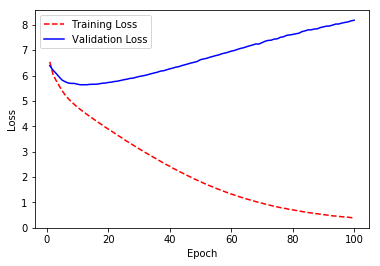

In [2]:
# Get training and validation loss histories
train_loss = []
with open("model_history_attempt3/loss_history_train.txt","r+") as file:
    for line in file:
        train_loss.append(float(line.split('\n')[0]))
        
val_loss = []
with open("model_history_attempt3/loss_history_val.txt","r+") as file:
    for line in file:
        val_loss.append(float(line.split('\n')[0]))
        
# Reference: https://chrisalbon.com/deep_learning/keras/visualize_loss_history/

# Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
test_X, test_Y = sentences_to_2darray(sentences_test)
print(test_X.shape)
print(test_Y.shape)

In [17]:
model_saved = keras.Sequential()
model_saved.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights_mini],trainable=False))
model_saved.add(LSTM(emdedding_size))
model_saved.add(Dropout(0.2))
model_saved.add(Dense(vocab_size, activation='softmax'))

model_saved.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [18]:
model_saved.load_weights('model_history_attempt2/checkpoint_model-013.hdf5')

In [22]:
def sample(a, temperature=1.0):
    # helper function to randomly select a word based on probability distribution
#     a = np.log(a) / temperature
#     a = np.exp(a) / np.sum(np.exp(a))
#     return np.argmax(np.random.multinomial(1, a, 1))
    
    # Reference: https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)


# Select a speech from the test file
# randint(a,b) selects from all integers between a and b (inclusive)
# The last speech has zero word, so instead of -1 use -2
gen_speech_index = random.randint(0, len(file_test.split("<speech_sep>"))-2)
# A list of words in the speech
list_words = file_test_google.split("<speech_sep>")[gen_speech_index].split()
# Select a starting point for the context
start_index = random.randint(0, len(list_words) - x_len - 1)

for diversity in [0.2, 0.5, 1.0, 1.2]:
    print()
    print('----- diversity:', diversity)
    generated = ''
    sentence = list_words[start_index: start_index + x_len]
    generated += ' '.join(sentence)
    print('----- Generating with seed: "' , sentence , '"')
    print()
    sys.stdout.write(generated)
    print()

    for i in range(50):
        x = np.zeros((1, x_len))
        for t, word in enumerate(sentence):
            if word in vocab:
                x[0, t] = word2idx(word)

        # model.predict(x, verbose=0).shape = (1, x_len)
        # model.predict(x, verbose=0)[0].shape = (x_len, )
        preds = model_saved.predict(x, verbose=0)[0]            
        next_index = sample(preds, diversity)
        next_word = idx2word(next_index)
        generated += next_word
        del sentence[0]
        sentence.append(next_word)
        sys.stdout.write(' ')
        sys.stdout.write(next_word)
        sys.stdout.flush()
    print()


----- diversity: 0.2
----- Generating with seed: " ['achieving', 'our', 'objectives', '.', 'America', 'will', 'do', 'what', 'we', 'must', 'To', 'prevent', 'A', 'nuclear', 'armed', 'Iran', '.', 'For', 'young', 'Israelis', ',', 'I', 'know', 'that', 'these', 'issues', 'Of', 'security', 'are', 'rooted'] "

achieving our objectives . America will do what we must To prevent A nuclear armed Iran . For young Israelis , I know that these issues Of security are rooted
 contained mean </s> race Allison surrounding police apathy Mike groundbreaking afterwards benefit fodder During becomes integrating caucus turn integrating Chiefs afterwards police moaning single afterwards benefit enforcing peoples Primas integrating art turn turn afterwards benefit enforcing thousand afterwards Truck Roll afterwards race courage becomes opportunity movie Roll movie Roll threw

----- diversity: 0.5
----- Generating with seed: " ['achieving', 'our', 'objectives', '.', 'America', 'will', 'do', 'what', 'we', 'must'